

```
# Añado libraries y funciones que puedan ser útiles
```



In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
from matplotlib.colors import ListedColormap
import plotly.express as px

import statistics as st
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import normalize
from sklearn.decomposition import PCA
from sklearn.cluster import DBSCAN
from sklearn.cluster import KMeans
from sklearn.preprocessing import LabelBinarizer
from sklearn.impute import SimpleImputer
import statistics
import plotly.graph_objects as go
import seaborn as sns
from sklearn.decomposition import KernelPCA
import time
from sklearn.datasets import make_moons
import plotly.io as plot_io
from sklearn import manifold
%matplotlib inline
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from numpy.random import rand, seed
from sklearn.neighbors import kneighbors_graph
from sklearn.datasets import make_blobs, make_circles, make_moons
from matplotlib.colors import ListedColormap
from sklearn.cluster import KMeans, SpectralClustering, DBSCAN, AgglomerativeClustering
from sklearn.mixture import GaussianMixture
from sklearn.metrics import adjusted_mutual_info_score
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
from sklearn.metrics import pairwise_distances
from datetime import datetime
from sklearn.manifold import TSNE
from mpl_toolkits.mplot3d import Axes3D

pd.set_option('display.max_columns', 500)
pd.set_option('display.max_rows', 5000)

%matplotlib inline

cm = plt.cm.RdBu
cm_bright = ListedColormap(['#FF0000', '#0000FF'])

import warnings
warnings.filterwarnings('ignore')

def plot_feature(df, col_name, isContinuous, target):
    f, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(12,3), dpi=90)
    
    count_null = df[col_name].isnull().sum()
    if isContinuous:
        
        sns.histplot(df.loc[df[col_name].notnull(), col_name], kde=False, ax=ax1)
    else:
        sns.countplot(df[col_name], order=sorted(df[col_name].unique()), color='#5975A4', saturation=1, ax=ax1)
    ax1.set_xlabel(col_name)
    ax1.set_ylabel('Count')
    ax1.set_title(col_name+ ' Numero de nulos: '+str(count_null))
    plt.xticks(rotation = 90)


    if isContinuous:
        sns.boxplot(x=col_name, y=target, data=df, ax=ax2)
        ax2.set_ylabel('')
        ax2.set_title(col_name + ' by '+target)
    else:
        data = df.groupby(col_name)[target].value_counts(normalize=True).to_frame('proportion').reset_index() 
        data.columns = [i, target, 'proportion']
        #sns.barplot(x = col_name, y = 'proportion', hue= target, data = data, saturation=1, ax=ax2)
        sns.barplot(x = col_name, y = 'proportion', hue= target, data = data, saturation=1, ax=ax2)
        ax2.set_ylabel(target+' fraction')
        ax2.set_title(target)
        plt.xticks(rotation = 90)
    ax2.set_xlabel(col_name)
    
    plt.tight_layout()
    

def dame_variables_categoricas(dataset=None):
    if dataset is None:
        print(u'\nFaltan argumentos por pasar a la función')
        return 1
    lista_variables_categoricas = []
    other = []
    for i in dataset.columns:
        if (dataset[i].dtype!=float) & (dataset[i].dtype!=int):
            unicos = int(len(np.unique(dataset[i].dropna(axis=0, how='all'))))
            if unicos < 100:
                lista_variables_categoricas.append(i)
            else:
                other.append(i)

    return lista_variables_categoricas, other


def get_corr_matrix(dataset = None, metodo='pearson', size_figure=[10,8]):
    # Para obtener la correlación de Spearman, sólo cambiar el metodo por 'spearman'
    if dataset is None:
        print(u'\nHace falta pasar argumentos a la función')
        return 1
    sns.set(style="white")
    # Compute the correlation matrix
    corr = dataset.corr(method=metodo) 
    # Set self-correlation to zero to avoid distraction
    for i in range(corr.shape[0]):
        corr.iloc[i, i] = 0
    # Set up the matplotlib figure
    f, ax = plt.subplots(figsize=size_figure)
    # Draw the heatmap with the mask and correct aspect ratio
    sns.heatmap(corr, center=0,
                square=True, linewidths=.5,  cmap ='viridis' ) #cbar_kws={"shrink": .5}
    plt.show()
    
    return 0

def get_deviation_of_mean_perc(pd_loan, list_var_continuous, target, multiplier):
    pd_final = pd.DataFrame()
    for i in list_var_continuous:
        
        series_mean = pd_loan[i].mean()
        series_std = pd_loan[i].std()
        std_amp = multiplier * series_std
        left = series_mean - std_amp
        right = series_mean + std_amp
        size_s = pd_loan[i].size
        
        perc_goods = pd_loan[i][(pd_loan[i] >= left) & (pd_loan[i] <= right)].size/size_s
        perc_excess = pd_loan[i][(pd_loan[i] < left) | (pd_loan[i] > right)].size/size_s
        
        if perc_excess>0:    
            pd_concat_percent = pd.DataFrame(pd_loan[target][(pd_loan[i] < left) | (pd_loan[i] > right)]\
                                            .value_counts(normalize=True).reset_index()).T
            pd_concat_percent.columns = [pd_concat_percent.iloc[0,0], 
                                         pd_concat_percent.iloc[0,1]]
            pd_concat_percent = pd_concat_percent.drop('index',axis=0)
            pd_concat_percent['variable'] = i
            pd_concat_percent['sum_outlier_values'] = pd_loan[i][(pd_loan[i] < left) | (pd_loan[i] > right)].size
            pd_concat_percent['porcentaje_sum_null_values'] = perc_excess
            pd_final = pd.concat([pd_final, pd_concat_percent], axis=0).reset_index(drop=True)
            
    if pd_final.empty:
        print('No existen variables con valores nulos')
        
    return pd_final


def get_percent_null_values_target(pd_loan, list_var_continuous, target):
    pd_final = pd.DataFrame()
    for i in list_var_continuous:
        if pd_loan[i].isnull().sum()>0:
            pd_concat_percent = pd.DataFrame(pd_loan[target][pd_loan[i].isnull()]\
                                            .value_counts(normalize=True).reset_index()).T
            pd_concat_percent.columns = [pd_concat_percent.iloc[0,0], 
                                         pd_concat_percent.iloc[0,1]]
            pd_concat_percent = pd_concat_percent.drop('index',axis=0)
            pd_concat_percent['variable'] = i
            pd_concat_percent['sum_null_values'] = pd_loan[i].isnull().sum()
            pd_concat_percent['porcentaje_sum_null_values'] = pd_loan[i].isnull().sum()/pd_loan.shape[0]
            pd_final = pd.concat([pd_final, pd_concat_percent], axis=0).reset_index(drop=True)
            
    if pd_final.empty:
        print('No existen variables con valores nulos')
        
    return pd_final



def cramers_v(confusion_matrix):
    chi2 = ss.chi2_contingency(confusion_matrix)[0]
    n = confusion_matrix.sum()
    phi2 = chi2 / n
    r, k = confusion_matrix.shape
    phi2corr = max(0, phi2 - ((k-1)*(r-1))/(n-1))
    rcorr = r - ((r-1)**2)/(n-1)
    kcorr = k - ((k-1)**2)/(n-1)
    return np.sqrt(phi2corr / min((kcorr-1), (rcorr-1)))

In [2]:
#Para la matriz de confusión 
def plot_confusion_matrix(confmat):
    fig, ax = plt.subplots(figsize=(3, 3))
    ax.matshow(confmat, cmap=plt.cm.Blues, alpha=0.5)
    for i in range(confmat.shape[0]):
        for j in range(confmat.shape[1]):
            ax.text(x=j, y=i, s=confmat[i, j], va='center', ha='center')

    plt.xlabel('predicted label')
    plt.ylabel('true label')

    plt.tight_layout()
    plt.show()

In [3]:
# Para calcular las métricas
def calcula_metricas(confmat):
    
    tn, fp, fn, tp = confmat.ravel() #para calcular y extraer valores

    acc = (tp+tn)/(tn + fp + fn + tp) #porcentaje de acierto
    sen = tp/(tp+fn) #
    esp = tn/(tn+fp) #
    ppv = tp/(tp+fp) #true positive
    fsc = 2*(sen*ppv/(sen+ppv)) # f1score

    print('ACC: ', acc)
    print('SEN: ', sen)
    print('ESP: ', esp)
    print('PPV: ', ppv)
    print('FSC: ', fsc)
    
    plt.bar(range(5),[acc,sen,esp,ppv,fsc])
    plt.xticks(range(5),['ACC','SEN','ESP','PPV','FSC'])
    plt.plot([-1, 6], [1, 1], color=(0.6, 0.6, 0.6), linestyle='--')
    plt.xlim((-0.5,4.5))
    plt.ylim((0,1.1))
    plt.title('Metricas')
    plt.show()

# 1. Añadimos el Dataset



```
# Importo los datos
```



In [4]:
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
import plotly.express as px

pd.set_option('display.max_columns', 500)
pd.set_option('display.max_rows', 5000)

In [5]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [6]:
carsdataset = pd.read_csv("/content/drive/MyDrive/clasificacion/practica final/NCDB_1999_to_2014.csv")
carsdataset.head()

,C_YEAR,C_MNTH,C_WDAY,C_HOUR,C_SEV,C_VEHS,C_CONF,C_RCFG,C_WTHR,C_RSUR,C_RALN,C_TRAF,V_ID,V_TYPE,V_YEAR,P_ID,P_SEX,P_AGE,P_PSN,P_ISEV,P_SAFE,P_USER
0,1999,1,1,20,2,02,34,UU,1,5,3,03,01,06,1990,01,M,41,11,1,UU,1
1,1999,1,1,20,2,02,34,UU,1,5,3,03,02,01,1987,01,M,19,11,1,UU,1
2,1999,1,1,20,2,02,34,UU,1,5,3,03,02,01,1987,02,F,20,13,2,02,2
3,1999,1,1,08,2,01,01,UU,5,3,6,18,01,01,1986,01,M,46,11,1,UU,1
4,1999,1,1,08,2,01,01,UU,5,3,6,18,99,NN,NNNN,01,M,05,99,2,UU,3


## Hacemos un análisis inicial

In [7]:
print(carsdataset.shape, carsdataset.drop_duplicates().shape)

(5860405, 22) (5855336, 22)


## Vemos cuantas variables missing hay

In [8]:
def missing_summary(dataframe): #definimos esta funcion para sacar los values missing
    num_elementos = carsdataset.count()
    num_missing = carsdataset.isna().sum()
    missing_summary = pd.DataFrame(index=num_elementos.index, 
                               data={'total':num_elementos, 
                                     'missing':num_missing,
                                     'missing_rate (%)': round(num_missing/num_elementos * 100, 2)})
    return missing_summary
missing_summary(carsdataset) #aplicamos la funcion a nuestro dataframe

,total,missing,missing_rate (%)
C_YEAR,5860405,0,0.0
C_MNTH,5860405,0,0.0
C_WDAY,5860405,0,0.0
C_HOUR,5860405,0,0.0
C_SEV,5860405,0,0.0
C_VEHS,5860402,3,0.0
C_CONF,5860405,0,0.0
C_RCFG,5860405,0,0.0
C_WTHR,5860405,0,0.0
C_RSUR,5860405,0,0.0


##comprobamos qué variables son númericas 

In [9]:
carsdataset.dtypes

C_YEAR     int64
C_MNTH    object
C_WDAY    object
C_HOUR    object
C_SEV      int64
C_VEHS    object
C_CONF    object
C_RCFG    object
C_WTHR    object
C_RSUR    object
C_RALN    object
C_TRAF    object
V_ID      object
V_TYPE    object
V_YEAR    object
P_ID      object
P_SEX     object
P_AGE     object
P_PSN     object
P_ISEV    object
P_SAFE    object
P_USER    object
dtype: object

##Convertimos las variables en númericas para poder operar mejor

In [10]:
carsdataset["C_MNTH"].replace({"UU": "0", "XX": "0"}, inplace=True)
carsdataset['C_MNTH'] = carsdataset['C_MNTH'].astype(int)

carsdataset["C_WDAY"].replace({"U": "0", "X": "0"}, inplace=True)
carsdataset['C_WDAY'] = carsdataset['C_WDAY'].astype(int)

carsdataset["C_HOUR"].replace({"UU": "0", "XX": "0"}, inplace=True)
carsdataset['C_HOUR'] = carsdataset['C_HOUR'].astype(int)

carsdataset["C_VEHS"].replace({"UU": "0", "XX": "0"}, inplace=True)
carsdataset['C_VEHS'] = carsdataset['C_VEHS'].fillna(0)
carsdataset['C_VEHS'] = carsdataset['C_VEHS'].astype(int)

carsdataset["C_CONF"].replace({"UU": "0", "XX": "0", "QQ": "0" }, inplace=True)
carsdataset['C_CONF'] = carsdataset['C_CONF'].astype(int)

carsdataset["C_RCFG"].replace({"UU": "0", "XX": "0", "QQ": "0" }, inplace=True)
carsdataset['C_RCFG'] = carsdataset['C_RCFG'].astype(int)

carsdataset["C_WTHR"].replace({"U": "0", "X": "0", "Q": "0" }, inplace=True)
carsdataset['C_WTHR'] = carsdataset['C_WTHR'].astype(int)

carsdataset["C_RSUR"].replace({"U": "0", "X": "0", "Q": "0" }, inplace=True)
carsdataset['C_RSUR'] = carsdataset['C_RSUR'].astype(int)

carsdataset["C_RALN"].replace({"U": "0", "X": "0", "Q": "0" }, inplace=True)
carsdataset['C_RALN'] = carsdataset['C_RALN'].astype(int)

carsdataset["C_TRAF"].replace({"UU": "0", "XX": "0", "QQ": "0" }, inplace=True)
carsdataset['C_TRAF'] = carsdataset['C_TRAF'].astype(int)

carsdataset["V_ID"].replace({"UU": "0"}, inplace=True)
carsdataset['V_ID'] = carsdataset['V_ID'].astype(int)

carsdataset["V_TYPE"].replace({"UU": "0", "XX": "0", "QQ": "0", "NN": "0"}, inplace=True)
carsdataset['V_TYPE'] = carsdataset['V_TYPE'].astype(int)

carsdataset["V_YEAR"].replace({"NNNN": "0", "UUUU": "0", "XXXX": "0" }, inplace=True)
carsdataset['V_YEAR'] = carsdataset['V_YEAR'].astype(int)

carsdataset["P_ID"].replace({"UU": "0", "NN": "0"}, inplace=True)
carsdataset['P_ID'] = carsdataset['P_ID'].astype(int)

carsdataset["P_SEX"].replace({"F": "1", "M": "1", "N": "0", "U": "0", "X": "0" }, inplace=True)
carsdataset['P_SEX'] = carsdataset['P_SEX'].astype(int) 
#SUSTITUIMOS LA F (sexo femenino) POR 1 Y LA M (sexo masculino) POR 2

carsdataset["P_AGE"].replace({"NN": "0","UU": "0", "XXXX": "0"}, inplace=True)
carsdataset['P_AGE'] = carsdataset['P_AGE'].astype(int)

carsdataset["P_PSN"].replace({"UU": "0", "XX": "0", "QQ": "0", "NN": "0"}, inplace=True)
carsdataset['P_PSN'] = carsdataset['P_PSN'].astype(int)

carsdataset["P_ISEV"].replace({"U": "0", "X": "0", "N": "0"}, inplace=True)
carsdataset['P_ISEV'] = carsdataset['P_ISEV'].astype(int)

carsdataset["P_SAFE"].replace({"UU": "0", "XX": "0", "QQ": "0", "NN": "0"}, inplace=True)
carsdataset['P_SAFE'] = carsdataset['P_SAFE'].astype(int)


carsdataset["P_USER"].replace({"U": "0"}, inplace=True)
carsdataset['P_USER'] = carsdataset['P_USER'].astype(int)

carsdataset.dtypes #para comprobar que todas se han pasado a int

C_YEAR    int64
C_MNTH    int64
C_WDAY    int64
C_HOUR    int64
C_SEV     int64
C_VEHS    int64
C_CONF    int64
C_RCFG    int64
C_WTHR    int64
C_RSUR    int64
C_RALN    int64
C_TRAF    int64
V_ID      int64
V_TYPE    int64
V_YEAR    int64
P_ID      int64
P_SEX     int64
P_AGE     int64
P_PSN     int64
P_ISEV    int64
P_SAFE    int64
P_USER    int64
dtype: object

*En este código, transformamos las variables que tomen valores categóricos a numéricos mediante la asignacion de un valor numérico a cada opcion que puede tomar la variable, por ejemplo en la variable P_SEX.
Además, eliminamos todos los NA sustituyendo aquellas filas que tengan una variable UU NN o XX (que representan valores desconocidos por 0, lo cual es mas útil ya que representa un valor numérico*

#2. ¿Qué tipos de vehículos (modelos, antigüedad, etc.) y conductores son más propensos a tener accidentes (acción correctiva en prima)?

##Para calcular el número de accidentes por modelo

In [11]:
cartype = carsdataset['V_TYPE']\
        .value_counts(normalize=True)\
        .mul(100).rename('percent').reset_index()

cartypecount = carsdataset['V_TYPE'].value_counts().reset_index()
cartypemerge = pd.merge(cartype, cartypecount, on=['index'], how='inner')
cartypemerge

,index,percent,V_TYPE
0,1,82.372976,4827390
1,0,4.830912,283111
2,6,2.994520,175491
3,17,2.097244,122907
4,14,2.094292,122734
5,7,1.502575,88057
6,8,1.203944,70556
7,5,1.128011,66106
8,11,0.874684,51260
9,9,0.356870,20914


In [12]:
import plotly.express as px
plot = px.histogram(cartypemerge, x="index", y=['percent'])
plot.show()

*Light Duty Vehicle (Passenger car, Passenger van, Light utility vehicles and light duty pick up trucks) [que corresponde con la variable 01] son los que mas accidentes provocan, provocan mas de un 80% de los accidentes
NN hace referencia a los vehiculos a los que no se les puede aplicar este elemento
En el siguiente lugar, estarían other trucks and vans [representado por 06] con cerca de un 3% de los accidentes. 
Luego las bicycle [17], con un 2%, etc.*

##Para calcular el número de  accidentes por antigüedad

In [13]:
año = carsdataset['V_YEAR']\
        .value_counts(normalize=True)\
        .mul(100).rename('percent').reset_index()

añocount = carsdataset['V_YEAR'].value_counts().reset_index()
añomerge = pd.merge(año, añocount, on=['index'], how='inner')
añomerge

,index,percent,V_YEAR
0,0,9.971632,584378
1,2000,5.514687,323183
2,1998,5.039089,295311
3,2002,5.008766,293534
4,1999,4.908193,287640
5,2003,4.769227,279496
6,2001,4.759057,278900
7,1997,4.478155,262438
8,2005,3.881609,227478
9,2004,3.850365,225647


In [14]:
import plotly.express as px
plot = px.histogram(añomerge, x="index", y=['percent'])
plot.show()

 *El porcentaje mayor de los accidentes estan provocados por coches con año desconocido. 
Obviando esto, los coches del año 2000 provocan mas de un 5,5% de los accidentes. 
Seguidos por los coches de 1998 y 2002, los cuales provocan cerca de un 5% de los accidentes.*

## Para calcular el número de  accidentes por person position

In [15]:
posicion = carsdataset['P_PSN']\
        .value_counts(normalize=True)\
        .mul(100).rename('percent').reset_index()

posicioncount = carsdataset['P_PSN'].value_counts().reset_index()
posicionmerge = pd.merge(posicion, posicioncount, on=['index'], how='inner')
posicionmerge

,index,percent,P_PSN
0,11,66.993425,3926086
1,13,15.093394,884534
2,23,4.404508,258122
3,21,3.685701,215997
4,99,3.564395,208888
5,0,1.666728,97677
6,22,1.541139,90317
7,12,1.495989,87671
8,96,0.748242,43850
9,32,0.513480,30092


In [16]:
import plotly.express as px
plot = px.histogram(posicionmerge, x="index", y=['percent'])
plot.show()

*La posición que produce mas accidentes es el driver (variable 11) con cerca de un 66% de los accidentes, le sigue front row, right outboard, including motorcycle passenger in sidecar (13) con cerca de un 15%. En tercera posicion estaría Second row, right outboard (23) con un 4,4% de los accidentes*

## Para calcular el número de accidentes por person age

In [17]:
edad = carsdataset['P_AGE']\
        .value_counts(normalize=True)\
        .mul(100).rename('percent').reset_index()

edadcount = carsdataset['P_AGE'].value_counts().reset_index()
edadmerge = pd.merge(edad, edadcount, on=['index'], how='inner')
edadmerge

,index,percent,P_AGE
0,0,6.742810,395156
1,18,2.930156,171719
2,19,2.861935,167721
3,20,2.708806,158747
4,17,2.698841,158163
5,21,2.520730,147725
6,22,2.361970,138421
7,23,2.227935,130566
8,24,2.086886,122300
9,25,2.018495,118292


In [18]:
import plotly.express as px
plot = px.histogram(edadmerge, x="index", y=['percent'])
plot.show()

*Las personas de 18 años son las mas comunes en los accidentes (2,9%), seguidos de los de 19 años (2,8%) y 20 (2,7%)*

## Para calcular el número de accidentes por sexo

In [19]:
sexo = carsdataset['P_SEX']\
        .value_counts(normalize=True)\
        .mul(100).rename('percent').reset_index()

sexocount = carsdataset['P_SEX'].value_counts().reset_index()
sexomerge = pd.merge(sexo, sexocount, on=['index'], how='inner')
sexomerge

,index,percent,P_SEX
0,1,95.73852,5610665
1,0,4.26148,249740


In [20]:
import plotly.express as px
plot = px.histogram(sexomerge, x="index", y=['percent'])
plot.show()

*Los hombres suelen tener mas accidentes que las mujeres*

#3.  ¿Qué tipos de vehículos (modelos, antigüedad, etc.) y conductores son menos propensos a tener accidentes (descuento en prima)?



*A partir del codigo anterior, podemos ver qué variables son las menos correlacionadas con el número de accidentes ordenandolo al revés*

##Modelo con menos accidentes

In [21]:
cartypeless = cartypemerge.sort_values('percent')
cartypeless

,index,percent,V_TYPE
17,21,0.014078,825
16,10,0.015460,906
15,19,0.034144,2001
14,23,0.052471,3075
13,18,0.053443,3132
12,22,0.078203,4583
11,20,0.130281,7635
10,16,0.165893,9722
9,9,0.356870,20914
8,11,0.874684,51260


In [22]:
import plotly.express as px
plot = px.histogram(cartypeless, x="index", y=['percent'])
plot.show()

*Los camiones de bomberos son los que menos accidentes sufren, seguidos de los autobuses escolares y en tercer lugar estan los vehículos utilizados en las granjas*

##Antiguedad de coches con menos accidentes

In [23]:
añoless = añomerge.sort_values('percent')
añoless

,index,percent,V_YEAR
114,1906,0.000017,1
113,1910,0.000017,1
111,1904,0.000034,2
112,1909,0.000034,2
110,1907,0.000034,2
109,1905,0.000051,3
108,1936,0.000051,3
107,1913,0.000068,4
106,1943,0.000068,4
105,1908,0.000085,5


In [24]:
import plotly.express as px
plot = px.histogram(añoless, x="index", y=['percent'])
plot.show()

*Los coches con menos accidentes son los de 1906, 1910 y 1904*

##Variable posición con menos accidentes

In [25]:
posicionless = posicionmerge.sort_values('percent')
posicionless

,index,percent,P_PSN
13,97,0.003259,191
12,31,0.077913,4566
11,33,0.098218,5756
10,98,0.113610,6658
9,32,0.513480,30092
8,96,0.748242,43850
7,12,1.495989,87671
6,22,1.541139,90317
5,0,1.666728,97677
4,99,3.564395,208888


In [26]:
import plotly.express as px
plot = px.histogram(posicionless, x="index", y=['percent'])
plot.show()

*La posición de los pasajeros con menos accidentes son Sitting on someone’s lap, Third row, left outboard y Third row, right outboard*

##Edad de conductor con menos accidentes

In [27]:
edadless = edadmerge.sort_values('percent')
edadless

,index,percent,P_AGE
99,97,0.001877,110
98,98,0.003293,193
97,96,0.003430,201
96,95,0.004983,292
95,99,0.005477,321
94,94,0.007730,453
93,93,0.011740,688
92,92,0.017490,1025
91,91,0.024384,1429
90,90,0.037404,2192


In [28]:
import plotly.express as px
plot = px.histogram(edadless, x="index", y=['percent'])
plot.show()

*La edad de personas con menos accidentes es 97, 98 y 96 años*

##Sexo de conductor con menos accidentes

In [29]:
sexoless = sexomerge.sort_values('percent')
sexoless

,index,percent,P_SEX
1,0,4.26148,249740
0,1,95.73852,5610665


In [30]:
import plotly.express as px
plot = px.histogram(sexoless, x="index", y=['percent'])
plot.show()

*Las mujeres tienen menos accidentes que los hombres*

# 4. ¿Qué es lo que más contribuye a que existan fallecimientos en un accidente?


## Normalizamos los datos

In [31]:
carsdata=pd.DataFrame(StandardScaler().fit_transform(carsdataset))
carsdata

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21
0,-1.531636,-1.663970,-1.556693,1.203674,0.130838,-0.035919,1.033606,-1.674207,-0.513058,3.077379,1.787408,-0.880683,-0.226502,1.087250,0.318568,-0.377846,0.210978,0.353657,-0.287643,-0.760451,-0.875495,-0.525247
1,-1.531636,-1.663970,-1.556693,1.203674,0.130838,-0.035919,1.033606,-1.674207,-0.513058,3.077379,1.787408,-0.880683,-0.172502,-0.321778,0.313558,-0.377846,0.210978,-0.749121,-0.287643,-0.760451,-0.875495,-0.525247
2,-1.531636,-1.663970,-1.556693,1.203674,0.130838,-0.035919,1.033606,-1.674207,-0.513058,3.077379,1.787408,-0.880683,-0.172502,-0.321778,0.313558,0.452050,0.210978,-0.698995,-0.177423,0.841054,0.013029,0.621712
3,-1.531636,-1.663970,-1.556693,-1.039169,0.130838,-0.824011,-1.570424,-1.674207,3.039112,1.310931,4.956637,0.943871,-0.226502,-0.321778,0.311888,-0.377846,0.210978,0.604288,-0.287643,-0.760451,-0.875495,-0.525247
4,-1.531636,-1.663970,-1.556693,-1.039169,0.130838,-0.824011,-1.570424,-1.674207,3.039112,1.310931,4.956637,0.943871,5.065510,-0.603584,-3.004546,-0.377846,0.210978,-1.450888,4.562005,0.841054,-0.875495,1.768671
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5860400,1.750721,-1.955199,-2.073922,-2.534398,0.130838,-1.612104,-1.649334,-0.577947,-1.401100,-1.338742,-1.381822,-1.245594,0.421499,1.369056,-3.004546,-0.377846,0.210978,-0.498489,-0.287643,-0.760451,-0.875495,-0.525247
5860401,1.750721,-1.955199,-2.073922,1.764385,0.130838,-0.824011,-1.175874,3.807097,-0.513058,-0.455517,-1.381822,0.943871,-0.226502,3.341695,0.345286,-0.377846,0.210978,-0.247858,4.396676,0.841054,3.122861,4.062590
5860402,1.750721,-1.955199,-2.073922,0.082252,0.130838,-0.824011,-1.491514,-0.577947,-0.513058,3.077379,2.843818,0.943871,-0.226502,-0.321778,0.345286,-0.377846,0.210978,-1.701520,-0.287643,0.841054,-0.431233,-0.525247
5860403,1.750721,-1.955199,-2.073922,1.577481,-7.643054,-0.824011,-1.175874,-0.577947,0.374985,2.194155,-1.381822,0.943871,-0.226502,5.596141,-3.004546,-0.377846,0.210978,1.656940,-0.232533,2.442558,-0.431233,-1.672207


## Hacemos un mapa de correlación

In [32]:
correlaciones = carsdataset.corr(method = 'pearson')
correlaciones

,C_YEAR,C_MNTH,C_WDAY,C_HOUR,C_SEV,C_VEHS,C_CONF,C_RCFG,C_WTHR,C_RSUR,C_RALN,C_TRAF,V_ID,V_TYPE,V_YEAR,P_ID,P_SEX,P_AGE,P_PSN,P_ISEV,P_SAFE,P_USER
C_YEAR,1.000000,-0.000542,-0.013736,-0.006808,0.005515,0.003677,-0.011980,0.008650,0.001523,0.012619,0.011708,-0.020221,0.019368,0.002704,0.001721,-0.003409,-0.041091,0.042390,0.003767,-0.020264,0.014028,-0.005339
C_MNTH,-0.000542,1.000000,0.003936,0.018760,-0.005877,-0.017344,-0.010349,-0.000635,-0.024494,-0.087627,0.000034,-0.000543,0.005513,0.013428,-0.012526,-0.000674,-0.006131,0.002433,0.007095,0.001774,0.005945,0.023512
C_WDAY,-0.013736,0.003936,1.000000,-0.013757,-0.018195,-0.016147,-0.018805,-0.013659,0.010693,0.000568,0.030662,0.023672,-0.020801,-0.018596,0.025924,0.050960,0.004147,-0.042479,-0.004334,0.005447,-0.007323,0.038284
C_HOUR,-0.006808,0.018760,-0.013757,1.000000,0.018129,0.022424,0.058805,0.017267,-0.020010,-0.040393,-0.036213,-0.030385,0.005023,0.003712,-0.008782,0.013768,0.002839,-0.014697,0.010935,-0.029675,0.012477,0.049248
C_SEV,0.005515,-0.005877,-0.018195,0.018129,1.000000,-0.017820,0.020953,0.027682,-0.018498,-0.007126,-0.059322,-0.060905,-0.019447,-0.027969,0.008976,-0.031769,-0.008592,-0.019447,-0.027770,-0.134780,-0.009124,-0.018691
C_VEHS,0.003677,-0.017344,-0.016147,0.022424,-0.017820,1.000000,0.231715,0.033541,0.032651,-0.019573,-0.064273,-0.021921,-0.112223,-0.023048,0.103964,0.006551,-0.017884,0.015500,-0.139697,-0.119426,-0.052858,-0.093104
C_CONF,-0.011980,-0.010349,-0.018805,0.058805,0.020953,0.231715,1.000000,0.208451,-0.056996,-0.089415,-0.144106,-0.242724,-0.209723,-0.000764,0.163677,0.012715,-0.004506,0.039656,-0.202514,-0.090619,-0.028516,-0.081713
C_RCFG,0.008650,-0.000635,-0.013659,0.017267,0.027682,0.033541,0.208451,1.000000,-0.011034,0.013195,0.094736,-0.199533,-0.001471,0.008642,0.007191,0.002324,-0.012655,0.025424,-0.025716,-0.028395,0.036966,0.007479
C_WTHR,0.001523,-0.024494,0.010693,-0.020010,-0.018498,0.032651,-0.056996,-0.011034,1.000000,0.443551,0.115525,0.077766,-0.010447,-0.033133,0.020160,0.016337,0.019453,0.000311,-0.017392,0.023577,-0.018159,-0.046756
C_RSUR,0.012619,-0.087627,0.000568,-0.040393,-0.007126,-0.019573,-0.089415,0.013195,0.443551,1.000000,0.156054,0.098000,-0.019205,-0.028682,0.021801,0.013275,-0.020669,-0.014531,-0.032705,0.025668,-0.015432,-0.070446


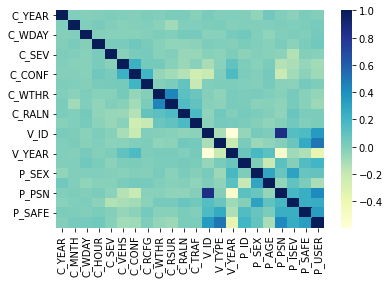

In [33]:
corr = pd.DataFrame(carsdataset).corr()
sns.heatmap(corr, cmap="YlGnBu")

*La variable que tiene que representa el numero de muertos en los accidentes es C_SEV, por lo que tenemos que mirar qué variable es la que está mas correlacionada con esta*

In [34]:
correlacionseveridad = correlaciones['C_SEV']
correlacionseveridad = abs(correlacionseveridad)
correlacionseveridad

C_YEAR    0.005515
C_MNTH    0.005877
C_WDAY    0.018195
C_HOUR    0.018129
C_SEV     1.000000
C_VEHS    0.017820
C_CONF    0.020953
C_RCFG    0.027682
C_WTHR    0.018498
C_RSUR    0.007126
C_RALN    0.059322
C_TRAF    0.060905
V_ID      0.019447
V_TYPE    0.027969
V_YEAR    0.008976
P_ID      0.031769
P_SEX     0.008592
P_AGE     0.019447
P_PSN     0.027770
P_ISEV    0.134780
P_SAFE    0.009124
P_USER    0.018691
Name: C_SEV, dtype: float64



```
# ponemos el valor absoluto de las variables para poder comparar la relación de todas las variables con c_sev, sin importar si 
la relación es positiva o negativa
```



In [35]:
correlacionseveridad.sort_values(ascending = False)

C_SEV     1.000000
P_ISEV    0.134780
C_TRAF    0.060905
C_RALN    0.059322
P_ID      0.031769
V_TYPE    0.027969
P_PSN     0.027770
C_RCFG    0.027682
C_CONF    0.020953
P_AGE     0.019447
V_ID      0.019447
P_USER    0.018691
C_WTHR    0.018498
C_WDAY    0.018195
C_HOUR    0.018129
C_VEHS    0.017820
P_SAFE    0.009124
V_YEAR    0.008976
P_SEX     0.008592
C_RSUR    0.007126
C_MNTH    0.005877
C_YEAR    0.005515
Name: C_SEV, dtype: float64

*Ordenando las variables por su correlacion con C_SEV averiguamos que la variable mas relacionada con esta es P_ISEV (Medical treatment required), lo cual estaba claro ya que a mayor gravedad del accidente, mayor necesidad de tratamiento médico.
La siguente variable mas correlacionada es C_TRAF que hace referencia a Traffic control, 
La tercera variable mas correlacionada es C_RALN, lo cual tiene que ver con el Road alignment*

# 5. Dado un accidente, ¿se puede generar un modelo que prediga si habrá fallecimientos o no? ¿Si se va a necesitar tratamiento médico o no? Las aseguradoras tienen que inmovilizar capital para pagar estas casuísticas. 



## Dividimos el conjunto de datos en train y test utilizando los datos normalizados

In [36]:
from sklearn.model_selection import train_test_split 
train, test = train_test_split(carsdata, test_size = 0.30)

print("Ejemplos usados para entrenar: ", len(train))
print("Ejemplos usados para test: ", len(test))

Ejemplos usados para entrenar:  4102283
Ejemplos usados para test:  1758122


## Regresión lineal

In [37]:
import numpy as np
from sklearn import datasets, linear_model
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.linear_model import LogisticRegression

In [38]:
carsdataset

,C_YEAR,C_MNTH,C_WDAY,C_HOUR,C_SEV,C_VEHS,C_CONF,C_RCFG,C_WTHR,C_RSUR,C_RALN,C_TRAF,V_ID,V_TYPE,V_YEAR,P_ID,P_SEX,P_AGE,P_PSN,P_ISEV,P_SAFE,P_USER
0,1999,1,1,20,2,2,34,0,1,5,3,3,1,6,1990,1,1,41,11,1,0,1
1,1999,1,1,20,2,2,34,0,1,5,3,3,2,1,1987,1,1,19,11,1,0,1
2,1999,1,1,20,2,2,34,0,1,5,3,3,2,1,1987,2,1,20,13,2,2,2
3,1999,1,1,8,2,1,1,0,5,3,6,18,1,1,1986,1,1,46,11,1,0,1
4,1999,1,1,8,2,1,1,0,5,3,6,18,99,0,0,1,1,5,99,2,0,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5860400,2014,0,0,0,2,0,0,1,0,0,0,0,13,7,0,1,1,24,11,1,0,1
5860401,2014,0,0,23,2,1,6,5,1,1,0,18,1,14,2006,1,1,29,96,2,9,5
5860402,2014,0,0,14,2,1,2,1,1,5,4,18,1,1,2006,1,1,0,11,2,1,1
5860403,2014,0,0,22,1,1,6,1,2,4,0,18,1,22,0,1,1,67,12,3,1,0


In [39]:
samples = carsdataset[['C_TRAF', 'C_RALN', 'C_SEV']].copy()
samples

,C_TRAF,C_RALN,C_SEV
0,3,3,2
1,3,3,2
2,3,3,2
3,18,6,2
4,18,6,2
...,...,...,...
5860400,0,0,2
5860401,18,0,2
5860402,18,4,2
5860403,18,0,1


In [40]:
regr = linear_model.LinearRegression()

model_rl = regr.fit(samples[['C_TRAF', 'C_RALN']], 
         samples['C_SEV'])
print(model_rl.intercept_, model_rl.coef_)



model_rl = regr.fit(carsdataset[['C_TRAF', 'C_RALN']], 
         carsdataset['C_SEV'])
print(model_rl.intercept_, model_rl.coef_)

2.000547684710526 [-0.00082018 -0.0068647 ]
2.000547684710526 [-0.00082018 -0.0068647 ]


In [41]:
y_test_prediction = model_rl.predict(pd.DataFrame({'C_TRAF':[300], 'C_RALN':[20]}))
y_test_prediction

array([1.61720074])

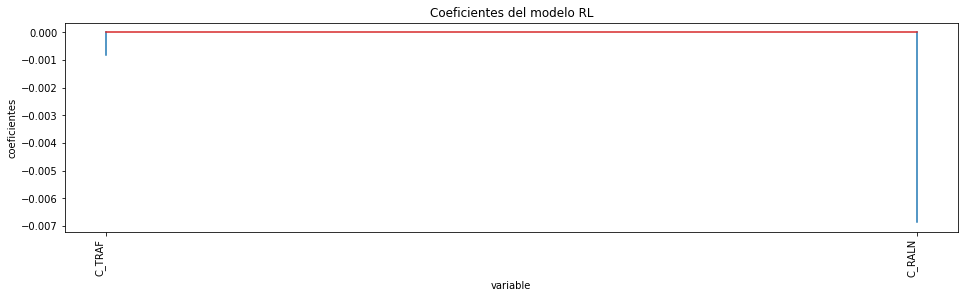

In [42]:
# Coeficientes del modelo
# ==============================================================================
df_coeficientes = pd.DataFrame(
                        {'predictor': samples[['C_TRAF', 'C_RALN']].columns,
                         'coef': model_rl.coef_}
                  )

fig, ax = plt.subplots(figsize=(16, 3.84))
ax.stem(df_coeficientes.predictor, df_coeficientes.coef, markerfmt=' ')
plt.xticks(rotation=90, ha='right', size=10)
ax.set_xlabel('variable')
ax.set_ylabel('coeficientes')
ax.set_title('Coeficientes del modelo RL');

## Regresión logística

### Función Sigmoide

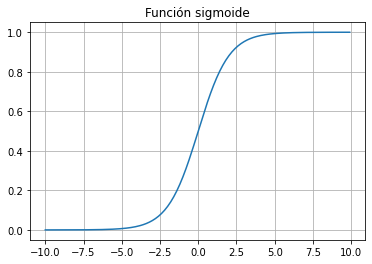

In [43]:
x = np.arange(-10,10,0.1)
y = 1/(1+np.exp(-x))
plt.title("Función sigmoide")
plt.plot(x,y)
plt.grid(True)
plt.show()

In [44]:
x = 2
y = 1/(1+np.exp(-x))
y

0.8807970779778823

In [45]:
x = 110
y = 1/(1+np.exp(-x))
y

1.0

###Ejemplo con scikit-learn

In [46]:
clf = LogisticRegression(solver='newton-cg', max_iter=500)
model_glm = clf.fit(samples[['C_TRAF', 'C_RALN']], 
                 samples['C_SEV'])

model_glm.predict_proba(pd.DataFrame({'C_TRAF':[300], 'C_RALN':[20]}))

array([[9.99999985e-01, 1.54750572e-08]])

In [47]:
df_coeficientes

,predictor,coef
0,C_TRAF,-0.000820
1,C_RALN,-0.006865


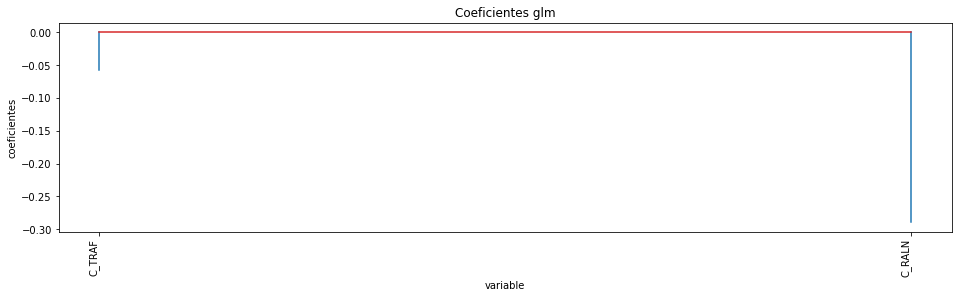

In [48]:
# Coeficientes del modelo
# ==============================================================================
df_coeficientes = pd.DataFrame(
                        {'predictor': samples[['C_TRAF', 'C_RALN']].columns,
                         'coef': model_glm.coef_.flatten()})

fig, ax = plt.subplots(figsize=(16, 3.84))
ax.stem(df_coeficientes.predictor, df_coeficientes.coef, markerfmt=' ')
plt.xticks(rotation=90, ha='right', size=10)
ax.set_xlabel('variable')
ax.set_ylabel('coeficientes')
ax.set_title('Coeficientes glm');

# 6. Libertad para generar análisis de valor y nuevas ideas. Se debe atacar mínimo un modelo (estimar si habrá fallecidos o no). Hecho esto, se puede plantear de forma opcional otros alcances (libertad para plantear opciones). 



## Análisis de mortalidad por cada día de la semana

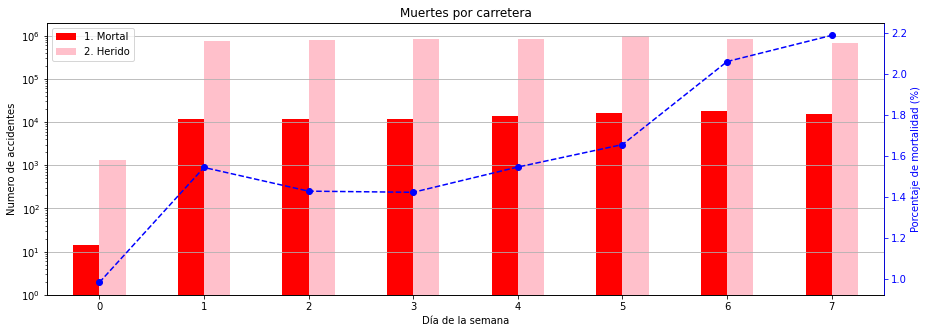

In [49]:
carretera = carsdataset.loc[:,['C_WDAY','C_SEV']]
fatal1 = carretera.groupby(['C_WDAY','C_SEV']).size().unstack()

fig,ax1 = plt.subplots()
ax2 = ax1.twinx()

fatal1.plot(kind='bar',rot=0,log=True,color=['red','pink'],figsize=(15,5),
         title='Muertes por carretera', ax=ax1)
ax1.set_ylabel('Numero de accidentes')
ax1.set_xlabel('Día de la semana')
ax1.grid(axis='y')
ax1.legend(['1. Mortal','2. Herido'])

se1 = fatal1[1]/(fatal1[1]+fatal1[2])*100
se1.plot(c='b', style='o--', ax=ax2)
ax2.set_ylabel('Porcentaje de mortalidad (%)')
ax2.spines['right'].set_color('b')
ax2.yaxis.label.set_color('b')
ax2.tick_params(axis='y',colors='b')

plt.xticks(np.arange(0,8));

## Análisis de mortalidad por condiciones climáticas

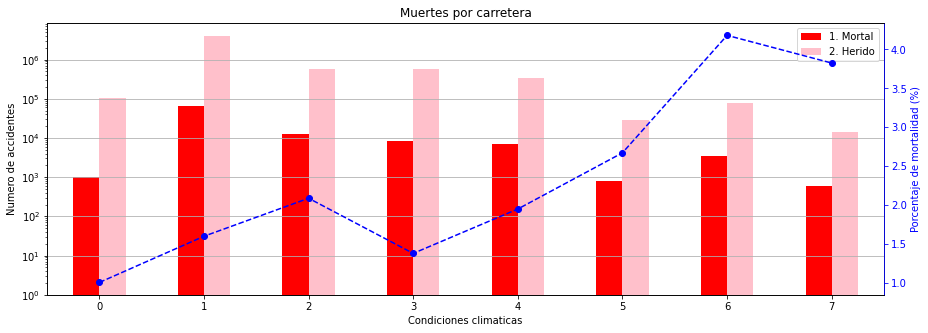

In [50]:
carretera = carsdataset.loc[:,['C_WTHR','C_SEV']]
fatal1 = carretera.groupby(['C_WTHR','C_SEV']).size().unstack()

fig,ax1 = plt.subplots()
ax2 = ax1.twinx()

fatal1.plot(kind='bar',rot=0,log=True,color=['red','pink'],figsize=(15,5),
         title='Muertes por carretera', ax=ax1)
ax1.set_ylabel('Numero de accidentes')
ax1.set_xlabel('Condiciones climaticas')
ax1.grid(axis='y')
ax1.legend(['1. Mortal','2. Herido'])

se1 = fatal1[1]/(fatal1[1]+fatal1[2])*100
se1.plot(c='b', style='o--', ax=ax2)
ax2.set_ylabel('Porcentaje de mortalidad (%)')
ax2.spines['right'].set_color('b')
ax2.yaxis.label.set_color('b')
ax2.tick_params(axis='y',colors='b')

plt.xticks(np.arange(0,8));

##Análisis de mortalidad por cada hora del día


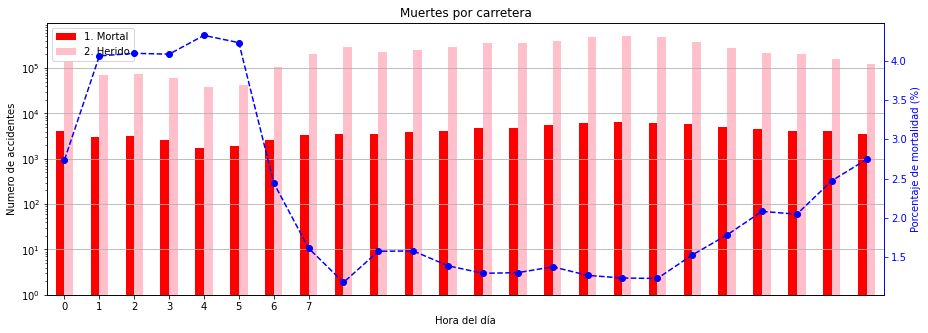

In [51]:
carretera = carsdataset.loc[:,['C_HOUR','C_SEV']]
fatal1 = carretera.groupby(['C_HOUR','C_SEV']).size().unstack()

fig,ax1 = plt.subplots()
ax2 = ax1.twinx()

fatal1.plot(kind='bar',rot=0,log=True,color=['red','pink'],figsize=(15,5),
         title='Muertes por carretera', ax=ax1)
ax1.set_ylabel('Numero de accidentes')
ax1.set_xlabel('Hora del día')
ax1.grid(axis='y')
ax1.legend(['1. Mortal','2. Herido'])

se1 = fatal1[1]/(fatal1[1]+fatal1[2])*100
se1.plot(c='b', style='o--', ax=ax2)
ax2.set_ylabel('Porcentaje de mortalidad (%)')
ax2.spines['right'].set_color('b')
ax2.yaxis.label.set_color('b')
ax2.tick_params(axis='y',colors='b')

plt.xticks(np.arange(0,8));

## Análisis de mortalidad por cada tipo de carretera


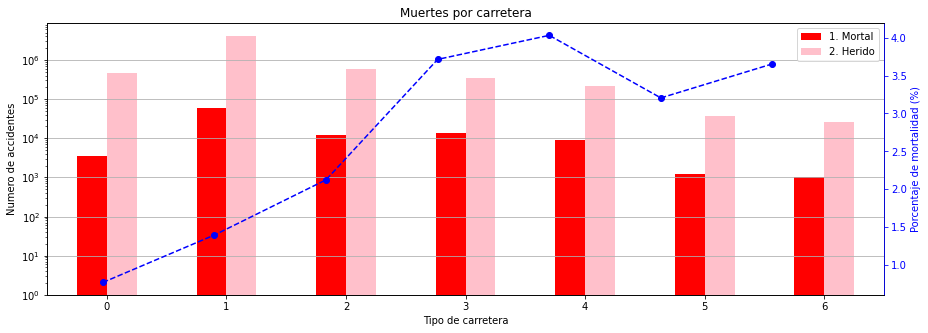

In [52]:
carretera = carsdataset.loc[:,['C_RALN','C_SEV']]
fatal1 = carretera.groupby(['C_RALN','C_SEV']).size().unstack()

fig,ax1 = plt.subplots()
ax2 = ax1.twinx()

fatal1.plot(kind='bar',rot=0,log=True,color=['red','pink'],figsize=(15,5),
         title='Muertes por carretera', ax=ax1)
ax1.set_ylabel('Numero de accidentes')
ax1.set_xlabel('Tipo de carretera')
ax1.grid(axis='y')
ax1.legend(['1. Mortal','2. Herido'])

se1 = fatal1[1]/(fatal1[1]+fatal1[2])*100
se1.plot(c='b', style='o--', ax=ax2)
ax2.set_ylabel('Porcentaje de mortalidad (%)')
ax2.spines['right'].set_color('b')
ax2.yaxis.label.set_color('b')
ax2.tick_params(axis='y',colors='b')

plt.xticks(np.arange(0,8));